# Malware Classification Project
## Project McNulty - Hasan Haq

In [310]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
%matplotlib inline

In [115]:
# make dummies: proto, dir, state, dport, TcpOpt, sHops, sTtl

# OneClassSVM instead of SVM

# Nested Cross Val

# Linear SVM

In [116]:
df = pd.read_csv('43/43_train.csv')

In [117]:
def label(df_in):
    labels = {'background': 'normal', 'normal': 'normal', 'botnet': 'botnet'}
    new_label = []
    for i in tqdm(df_in['Label']):
        if 'botnet' in i.lower():
            new_label.append('botnet')
        else:
            new_label.append('normal')
    df_in['Label'] = new_label
    return df_in

In [118]:
df = df.drop(['SIntPkt'], axis=1)
df = label(df)

100%|██████████| 1808122/1808122 [00:01<00:00, 942470.99it/s] 


In [420]:
def clean(df_in):
    df_new = df_in.copy(deep=True)
    
    # Big assumptions here... so far all the test sets fit it...
    #   Cuts total data from 1.8mm to 200k, and keeps all malware data
    df_new = df_in.loc[df_in['sHops'] == 1]
    df_new = df_in.loc[df_in['sTtl'] == 127]
    df_new['Load'] = df_in['Load'].map(lambda x: 1 if x>0 else 0)

    # Another assumption, that the ports, state and protocol that Neris uses here will be used in future test sets
    #  Cuts it down even further, down to 150k
    ports = df_in.loc[df_in['Label'] == "botnet"]['Dport'].unique()
    states = df_in.loc[df_in['Label'] == "botnet"]['State'].unique()
    protos = df_in.loc[df_in['Label'] == "botnet"]['Proto'].unique()

    df_new = df_new.loc[(df_new['Dport'].isin(ports)) & (df_new['State'].isin(states)) & (df_new['Proto'].isin(protos))]
    df_new['TotBytes'] = df_new['TotBytes'].astype('float64')
    df_new['TotPkts'] = df_new['TotPkts'].astype('float64')
    
    # Clean up direction labels before dummying
    df_new['Dir'] = df_new['Dir'].map(lambda x: "<->" if x=="  <->" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "->" if x=="   ->" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "<->" if x=="  <?>" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "<-" if x=="  <-" else x)
    df_new['Dir'] = df_new['Dir'].map(lambda x: "->" if x=="   ?>" else x)
    print(pd.isnull(df_new).any())
    return df_new

def clean_for_orig(df_in):
    _y = df_in['Label']
    X = df_in.drop(['StartTime', 'SrcAddr', 'Sport', 'DstAddr', 'Label', 'sHops', 'sTtl'], axis=1) # Cols we def won't need
    X = X[['sMaxPktSz', 'pLoss', 'Dur', 'sMeanPktSz', 'TotBytes', 'TotAppByte', 'State']]
#     X = X.drop(['TcpOpt', 'SrcBytes', 'Load', 'SrcJitter', 'PCRatio', 'TotPkts'], axis=1) # Cols we might need
    X_dum = pd.get_dummies(X, drop_first=True, columns=['State']) # Make dummies
    X_new = X_dum[['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes', 'TotAppByte']] # Selected based on Rand Forest Feature Selection
    X_new = X_new.fillna(X_new.mean())
    print(pd.isnull(X_new).any())
    return X_new, _y

In [421]:
df_clean = clean(df)
df_clean.info()

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


StartTime     False
Dur           False
Proto         False
SrcAddr       False
Sport         False
Dir           False
DstAddr       False
Dport         False
State         False
TotPkts       False
TotBytes      False
sMaxPktSz     False
sMinPktSz     False
sMeanPktSz    False
SrcBytes      False
TotAppByte    False
TcpOpt         True
sTtl          False
sHops         False
pLoss         False
Load          False
SrcJitter      True
PCRatio       False
Label         False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149459 entries, 8 to 1808116
Data columns (total 24 columns):
StartTime     149459 non-null object
Dur           149459 non-null float64
Proto         149459 non-null object
SrcAddr       149459 non-null object
Sport         149459 non-null object
Dir           149459 non-null object
DstAddr       149459 non-null object
Dport         149459 non-null object
State         149459 non-null object
TotPkts       149459 non-null float64
TotBytes      149459 non

In [423]:
X_for, y = clean_for_orig(df_clean)

sMaxPktSz     False
pLoss         False
State_REQ     False
Dur           False
sMeanPktSz    False
TotBytes      False
TotAppByte    False
dtype: bool


In [241]:
# df.to_pickle('flows.pkl')
# df_clean.to_pickle('flows_clean.pkl')
# df = pd.read_pickle('flows.pkl')
# df_clean = pd.read_pickle('flows_clean.pkl')

In [242]:
X_for.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149459 entries, 8 to 1808116
Data columns (total 6 columns):
sMaxPktSz     149459 non-null float64
pLoss         149459 non-null float64
State_REQ     149459 non-null float64
Dur           149459 non-null float64
sMeanPktSz    149459 non-null float64
TotBytes      149459 non-null float64
dtypes: float64(6)
memory usage: 8.0 MB


In [424]:
y_bin = [0 if i == 'normal' else 1 for i in y]

In [425]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_for, y_bin, test_size=0.3, stratify=y_bin)

In [426]:
# Standardize the data
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [344]:
%%timeit -n1 -r1
# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_score = cross_val_score(knn, X_train, y_train, cv=10, scoring="f1")
print(knn_score)

[ 0.95486111  0.94846074  0.94568245  0.94203402  0.94322536  0.94342242
  0.94918769  0.95751295  0.94725957  0.94459834]
1 loop, best of 1: 6.97 s per loop


In [428]:
%%timeit -n1 -r1
# Logistic Regression
logreg = LogisticRegression()
log_acc = cross_val_score(logreg, X_train, y_train, cv=10, scoring="f1")
print(log_acc)

[ 0.82945441  0.73552686  0.8214826   0.77809331  0.82884903  0.75615764
  0.75324675  0.82464097  0.82041588  0.82583622]
1 loop, best of 1: 24.2 s per loop


In [162]:
%%timeit -n1 -r1
# Gaussian Naive Bayes
gauss = GaussianNB()
gauss_acc = cross_val_score(gauss, X_train, y_train, cv=10, scoring='f1')
print(gauss_acc)

[ 0.26011614  0.26020736  0.26516432  0.26268602  0.2618369   0.26027775
  0.26128266  0.26495009  0.26186971  0.26240741]
1 loop, best of 1: 1.39 s per loop


In [247]:
%%timeit -n1 -r1
# Random Forests
forest = RandomForestClassifier()
forest_acc = cross_val_score(forest, X_train, y_train, cv=10, scoring='f1')
print(forest_acc)

[ 0.96510816  0.96409899  0.95887522  0.95893296  0.95831874  0.95997191
  0.9584932   0.96794425  0.96293706  0.95896177]
1 loop, best of 1: 15 s per loop


In [205]:
X_train.columns[[3,5 ]]

Index(['Dur', 'TotBytes'], dtype='object')

Feature ranking:
1. feature 1 (0.353124)
2. feature 0 (0.227481)
3. feature 4 (0.162839)
4. feature 3 (0.073679)
5. feature 5 (0.063076)
6. feature 6 (0.059958)
7. feature 2 (0.059844)


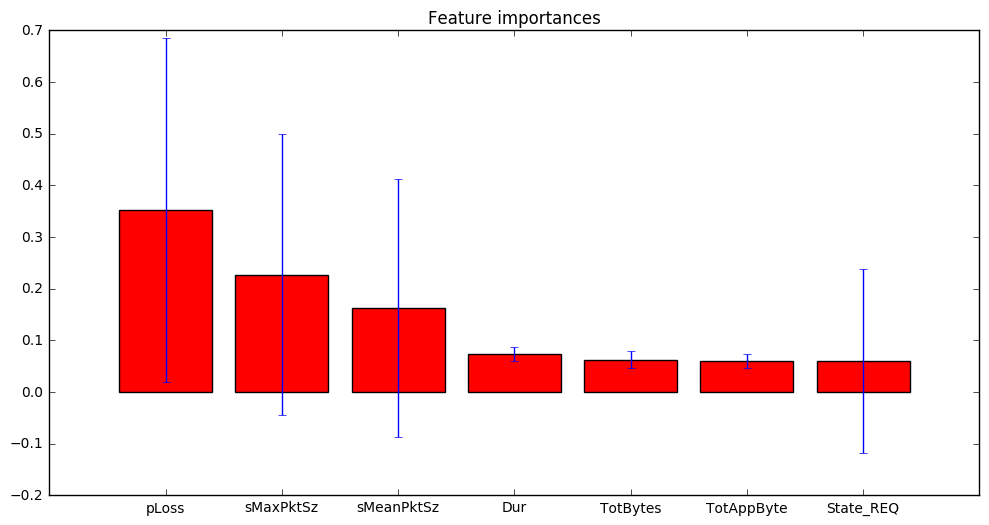

1 loop, best of 1: 2.27 s per loop


In [427]:
%%timeit -n1 -r1
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

labs = []
for _ in indices:
    labs.append(X_train.columns[_])

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
fig = plt.figure()
fig.set_size_inches(12, 6, forward=True)
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), labs)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [321]:
n_classes = 2

classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

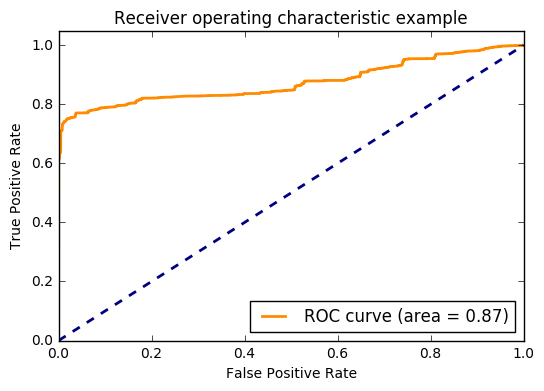

In [324]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Out of Sample Testing

## Stratified Sample

### Random Forests

In [308]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)
ypred_for = forest.predict(X_test)

In [309]:
print("accuracy: ", accuracy_score(y_test, ypred_for))
print("precision: ", precision_score(y_test, ypred_for))
print("recall: ", recall_score(y_test, ypred_for))
print("f1 score: ", f1_score(y_test, ypred_for))

accuracy:  0.989740844819
precision:  0.984843437708
recall:  0.941260744986
f1 score:  0.962559010256


###  Logistic Regression

In [342]:
logreg = LogisticRegression(class_weight={1: 20})
logreg.fit(X_train,y_train)
ypred_log = logreg.predict(X_test)

In [343]:
print("accuracy: ", accuracy_score(y_test, ypred_log))
print("precision: ", precision_score(y_test, ypred_log))
print("recall: ", recall_score(y_test, ypred_log))
print("f1 score: ", f1_score(y_test, ypred_log))

accuracy:  0.759757348677
precision:  0.355534105534
recall:  0.879496975486
f1 score:  0.506369718633


### KNN

In [375]:
knn = KNeighborsClassifier()
knn.fit(std_scale.transform(X_for), y_bin)
ypred_knn = knn.predict(std_scale.transform(X_test))

In [376]:
print("accuracy: ", accuracy_score(y_test, ypred_knn))
print("precision: ", precision_score(y_test, ypred_knn))
print("recall: ", recall_score(y_test, ypred_knn))
print("f1 score: ", f1_score(y_test, ypred_knn))

accuracy:  0.987577501227
precision:  0.973845389836
recall:  0.936485195798
f1 score:  0.95479996754


## New Sample

In [167]:
df_50 = pd.read_csv('50/test_50.csv')

In [168]:
df_50 = label(df_50)

100%|██████████| 2087508/2087508 [00:02<00:00, 832400.44it/s]


In [429]:
def clean_bot(df_in):
    df_in = df_in.drop(['SIntPkt'], axis=1)
    df_new = df_in.copy(deep=True)
    
    df_new = df_in.loc[df_in['sHops'] == 1]
    df_new = df_in.loc[df_in['sTtl'] == 127]
    df_new['Load'] = df_in['Load'].map(lambda x: 1 if x>0 else 0)

    df_new['TotBytes'] = df_new['TotBytes'].astype('float64')
    df_new['TotPkts'] = df_new['TotPkts'].astype('float64')
    print(pd.isnull(df_new).any())
    return df_new

def clean_for_bot(df_in):
    df_in = df_in.dropna(subset=['sMaxPktSz'])
    _y = df_in['Label']
    X = df_in.drop(['StartTime', 'SrcAddr', 'Sport', 'DstAddr', 'Label', 'sHops', 'sTtl'], axis=1) # Cols we def won't need
    X = X.drop(['Dir', 'TcpOpt', 'SrcBytes', 'Load', 'SrcJitter', 'PCRatio', 'TotPkts'], axis=1) # Cols we might need
    X_dum = pd.get_dummies(X, drop_first=True, columns=['Proto', 'Dport', 'State']) # Make dummies
    X_new = X_dum[['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes', 'TotAppByte']] # Selected based on Rand Forest Feature Selection
    X_new = X_new.fillna(X_new.mean())
    print(pd.isnull(X_new).any())
    return X_new, _y

In [251]:
df_50['Label'].value_counts()

normal    1902521
botnet     184987
Name: Label, dtype: int64

In [252]:
df_50_clean['Label'].value_counts()

botnet    184987
normal    151455
Name: Label, dtype: int64

In [430]:
df_50_clean = clean(df_50)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


StartTime     False
Dur           False
Proto         False
SrcAddr       False
Sport         False
Dir           False
DstAddr       False
Dport         False
State         False
TotPkts       False
TotBytes      False
sMaxPktSz      True
sMinPktSz      True
sMeanPktSz    False
SrcBytes      False
TotAppByte    False
TcpOpt         True
sTtl          False
sHops         False
pLoss         False
Load          False
SrcJitter      True
PCRatio       False
Label         False
dtype: bool


In [431]:
X_50, y_50 = clean_for_bot(df_50_clean)

sMaxPktSz     False
pLoss         False
State_REQ     False
Dur           False
sMeanPktSz    False
TotBytes      False
TotAppByte    False
dtype: bool


In [432]:
y50_bin = [0 if i == 'normal' else 1 for i in y_50]

In [256]:
sum(y50_bin)/len(y50_bin)

0.5498365236000475

In [194]:
X_50.columns

Index(['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes'], dtype='object')

In [195]:
X_for.columns

Index(['sMaxPktSz', 'pLoss', 'State_REQ', 'Dur', 'sMeanPktSz', 'TotBytes'], dtype='object')

### Random Forests 

In [435]:
forest_50 = RandomForestClassifier()
forest_50.fit(X_for,y_bin)
# ypred_prob = forest.predict_proba(X_50)
ypred_50 = forest_50.predict(X_50)

In [436]:
print("Accuracy: ", accuracy_score(y50_bin, ypred_50))
print("Precision: ", precision_score(y50_bin, ypred_50))
print("Recall: ", recall_score(y50_bin, ypred_50))
print("F1: ", f1_score(y50_bin, ypred_50))

Accuracy:  0.639861490905
Precision:  0.988712938005
Recall:  0.348992091336
F1:  0.515888014767


### Logistic Regression 

In [433]:
logreg_50 = LogisticRegression(class_weight={1: 50})
logreg_50.fit(std_scale.transform(X_for),y_bin)
ypred_50_log = logreg_50.predict(std_scale.transform(X_50))

In [434]:
print("Accuracy: ", accuracy_score(y50_bin, ypred_50_log))
print("Precision: ", precision_score(y50_bin, ypred_50_log))
print("Recall: ", recall_score(y50_bin, ypred_50_log))
print("F1: ", f1_score(y50_bin, ypred_50_log))

Accuracy:  0.569483414576
Precision:  0.561514321265
Recall:  0.990453383211
F1:  0.716707902637


### KNN

In [437]:
# KNN
knn_50 = KNeighborsClassifier(weights="distance")
knn_50.fit(std_scale.transform(X_for), y_bin)
ypred_50_knn = knn_50.predict(std_scale.transform(X_50))

In [438]:
print("Accuracy: ", accuracy_score(y50_bin, ypred_50_knn))
print("Precision: ", precision_score(y50_bin, ypred_50_knn))
print("Recall: ", recall_score(y50_bin, ypred_50_knn))
print("F1: ", f1_score(y50_bin, ypred_50_knn))

Accuracy:  0.648183925811
Precision:  0.966932996916
Recall:  0.372896473806
F1:  0.538226562165
